# Introduction to Graph data with PyTorch Geometric
by @moaziat 

### Graphs + Neural networks = NaN??

Graphs are kind of data structure which models a set of objects (Nodes) and their and their relationships (edges). As a unique non-Euclidien data structure for ML, graph analysis focues on tasks such as node classification, link prediction, and clustering. Graph Neural Networks (GNNs) are deep learning based methods that operate on graph domain. 
We denote a graph as $ G = (V, E) $, where $|V| = N$ : number of nodes in the graph  and $ |V| = N^e$: number of edges.

### General design pipline of GNNs

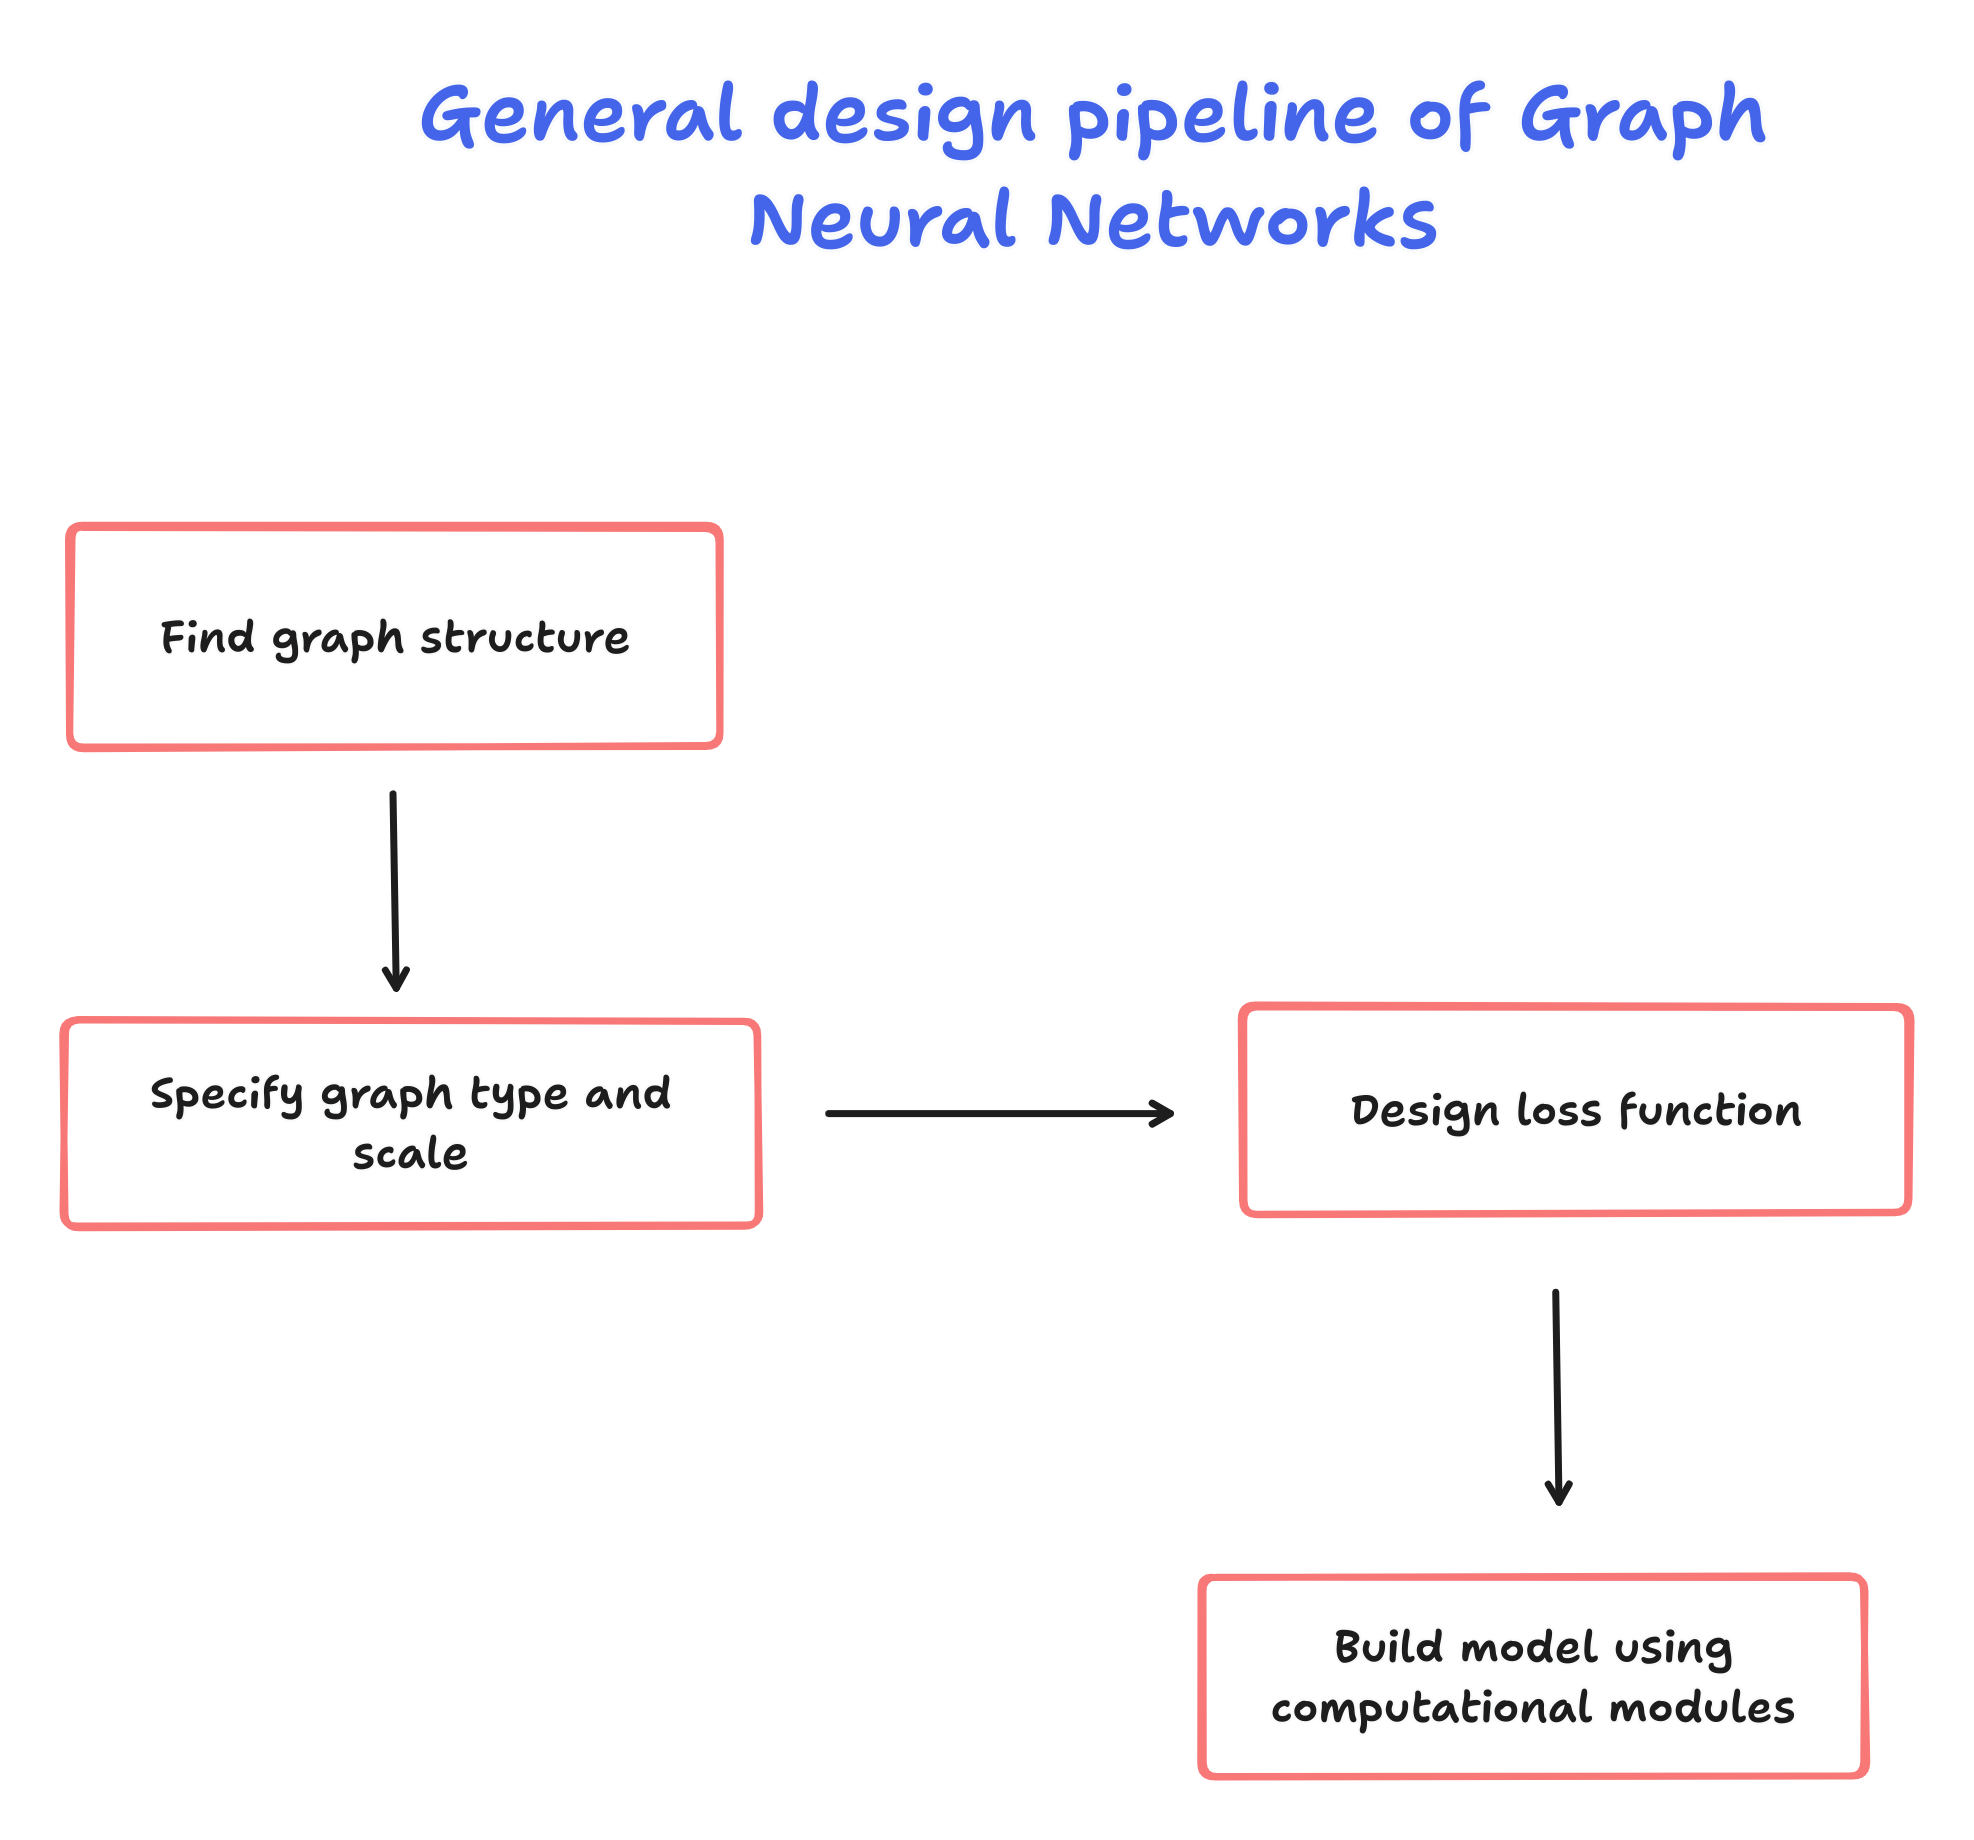

In [7]:
from IPython.display import Image
Image("pipeline_.png")

### Graph type?

- **Directed/Undirected graphs:** Directed graphs are the ones where edges are directed from oned node to another, while undirected graphs can b seen as two directed graphs
- **Homogeneous/Heterogeneous graphs:** If nodes and edges are of the same type then the graph is homogeneous. Else, the graph is heterogeneous.
- **Static/Dynamic graphs:** Graphs are dynamic when input features or the topology of the graph vary with time. 

In [1]:
import torch
import networkx as nx 
import matplotlib.pyplot as plt

In [2]:
"""
A function to visualize a graph data
"""

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

Pytorch geometic provides a bunch of graph datasets here: 
https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/datasets.html 

We are going to use the GeometricShapes dataset (I love geometry)

In [5]:
from torch_geometric.datasets import KarateClub

"""
GeoemtricShapes requires one positional argument root directory where the dataset should be saved
"""

dir = "mo/home/Desktop" 
dataset = KarateClub()

### Explore the the graph dataset (fancy wording huh!)

In [6]:
print('Dataset properties')
print('==============================================================')
print(f'Dataset: {dataset}') #This prints the name of the dataset
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Number of features each node in the dataset has
print(f'Number of classes: {dataset.num_classes}') #Number of classes that a node can be classified into


#Since we have one graph in the dataset, we will select the graph and explore it's properties

data = dataset[0]
print('Graph properties')
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}') #Number of nodes in the graph
print(f'Number of edges: {data.num_edges}') #Number of edges in the graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average number of nodes in the graph
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #Does the graph contains nodes that are not connected

print(f'Contains self-loops: {data.has_self_loops()}') #Does the graph contains nodes that are linked to themselves

print(f'Is undirected: {data.is_directed()}') #Is the graph an undirected graph

Dataset properties
Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4
Graph properties
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: False


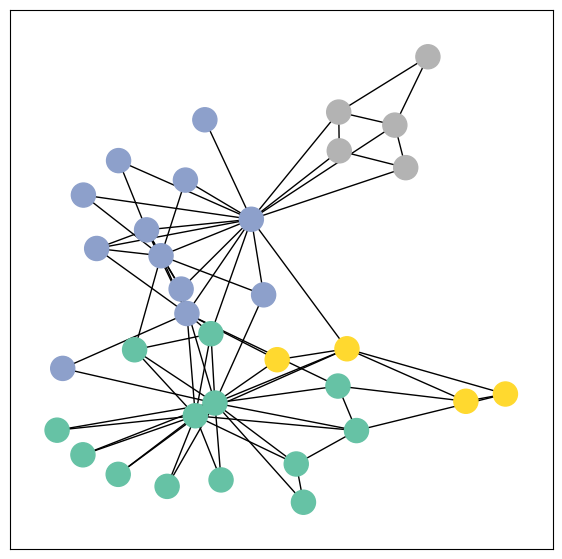

In [10]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

### Implement?

A simple GNN? Like a simple Graph? whut? 
When building a GNN model there are three modules to take into account: 
* **Propagation module** : Propagate information between nodes so that the aggregated information could capture both feature and topological info. How? We use the convolution operator to aggregate information from neighbours. 
* **Sampling module** : Needed when the graph is large to conduct propagation on graphs. This module is usually combined with the propagator module. 
* **Pooling module**: Used when we need the representations of high-level subgraphs or graphs, pooling modules are needed to extract info from nodes 

### Too much! Right? 

We will start with a simple GNN which is Graph Convolution Network (GCN). We're going to stack thre graph convolution layers, which corresponds to aggregating 3-hop neighborhood information around each node (Propagation module). 
The GCNConv layers reduce dimensionality to 2. $|V| → 4 → 4 → 2$. 

With basic deep learning knowledge, we enhance each GCNConv layer by a tanh (Non-linearity) then apply a linear layer to which acts a classifier to map the nodes to 1 out of the 4 possible classes. 

In [13]:
from torch_geometric.nn import GCNConv 
from torch.nn import Linear 
class SimpleGNN(torch.nn.Module): 
    def __init__(self): 
        super(SimpleGNN, self).__init__()
        torch.manual_seed(42) #42 huh? lol 
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    #forward pass as usual 
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h
model = SimpleGNN()
print(model)

SimpleGNN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


### Did you forget? Remember me? backward pass? Loss? Training? 

Imagine your first learning about Graphs or GNNs. Scary, you may think you'll have to invent a better optimizer than **Adam optimizer**, of course not!! We're going to use the Adam optimizer, and CrossEntropyLoss (this one is scary, you'll have to design your own loss function when working on a complex project). 

In [14]:
model = SimpleGNN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad() # Do not forget this one. Everone makes this mistake even Karpathy himself 
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  
    optimizer.step()  
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')
   

Epoch: 0, Loss: 1.3995898962020874
Epoch: 1, Loss: 1.3748631477355957
Epoch: 2, Loss: 1.354474663734436
Epoch: 3, Loss: 1.3380006551742554
Epoch: 4, Loss: 1.3248088359832764
Epoch: 5, Loss: 1.313724160194397
Epoch: 6, Loss: 1.3034374713897705
Epoch: 7, Loss: 1.292889952659607
Epoch: 8, Loss: 1.2814385890960693
Epoch: 9, Loss: 1.268866777420044
Epoch: 10, Loss: 1.255289912223816
Epoch: 11, Loss: 1.2410117387771606
Epoch: 12, Loss: 1.226381540298462
Epoch: 13, Loss: 1.2116938829421997
Epoch: 14, Loss: 1.1971179246902466
Epoch: 15, Loss: 1.1826605796813965
Epoch: 16, Loss: 1.1681735515594482
Epoch: 17, Loss: 1.1534196138381958
Epoch: 18, Loss: 1.1381779909133911
Epoch: 19, Loss: 1.1223535537719727
Epoch: 20, Loss: 1.1060408353805542
Epoch: 21, Loss: 1.0894984006881714
Epoch: 22, Loss: 1.0730408430099487
Epoch: 23, Loss: 1.0569096803665161
Epoch: 24, Loss: 1.0411953926086426
Epoch: 25, Loss: 1.0258550643920898
Epoch: 26, Loss: 1.0108050107955933
Epoch: 27, Loss: 0.9960232973098755
Epoch: 2

We will explore more datasets from PyG module in the next notebooks, different type of GNNs...
Reference: https://arxiv.org/pdf/1812.08434 